# Evaluation of Profile detector

### Environment

Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader, random_split

from test import evaluate, confusion
from train import train
from dataset import ProfileDataset
from model import ProfileDetector

Directories

In [17]:
TRAIN_DATA_PATH = '../dataset/train'
TEST_DATA_PATH = '../dataset/train'
MODEL_DIR = './trained_models'

Make plots wider

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

### Search hyper parameters

In [4]:
epochs = 50
hyper_params = [
    {"lr": 1e-3, "wd": 1e-4},
    {"lr": 3e-3, "wd": 1e-4},
    {"lr": 7e-3, "wd": 1e-4},
    {"lr": 1e-2, "wd": 1e-4},
    {"lr": 1e-2, "wd": 1e-4},
    {"lr": 3e-2, "wd": 1e-4},
    {"lr": 5e-2, "wd": 1e-4},
    {"lr": 1e-3, "wd": 1e-4},
    {"lr": 1e-3, "wd": 1e-3},
    {"lr": 1e-3, "wd": 1e-5},
    {"lr": 1e-3, "wd": 1e-2},]

# Check if CUDA support is available (GPU)
use_cuda = torch.cuda.is_available()

for hypers in hyper_params:
    lr, wd = hypers['lr'], hypers['wd']
    dataset = ProfileDataset(TRAIN_DATA_PATH)
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(dataset, [0.9, 0.1], generator)

    train_loader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, generator=generator)
    print(f"Loaded train dataset with {len(train_dataset)} images.")

    val_loader = DataLoader(val_dataset, batch_size=64,
                            shuffle=True, generator=generator)
    print(f"Loaded validation dataset with {len(val_dataset)} images.")

    # Load and initialize the network architecture
    model = ProfileDetector(pretrained=True, freeze_backbone=True)

    if use_cuda:
        model.cuda()
        cudnn.benchmark = True

    # The objective (loss) function
    objective = nn.BCELoss()

    # The optimizer used for training the model
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    model, loss_log, acc_log = train(model=model,
                                     train_data=train_loader,
                                     val_data=val_loader,
                                     optimizer=optimizer,
                                     objective=objective,
                                     use_cuda=use_cuda,
                                     epochs=epochs,
                                     name=f"profile_lr{lr}_wd{wd}")

Loaded train dataset with 905 images.
Loaded validation dataset with 100 images.

Epoch: 1
             Loss               Acc               
Train        0.64713176         64.31             
Val          0.64743128         60.00             

Epoch: 2
             Loss               Acc               
Train        0.60863654         66.19             
Val          0.61948591         65.00             

Epoch: 3
             Loss               Acc               
Train        0.56843252         71.16             
Val          0.65608588         61.00             

Epoch: 4
             Loss               Acc               
Train        0.57546423         70.17             
Val          0.54698998         69.00             

Epoch: 5
             Loss               Acc               
Train        0.50863344         74.92             
Val          0.66324463         61.00             

Epoch: 6
             Loss               Acc               
Train        0.57984444         69.83      

### Model and dataset

In [5]:
model_path = Path(MODEL_DIR) / 'profile_detector_best'
model = ProfileDetector(pretrained=True, freeze_backbone=True)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
test_dataset = ProfileDataset(TEST_DATA_PATH, augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Loaded test dataset with {len(test_dataset)} images.")

Loaded test dataset with 1005 images.


### Load loss and accuracy

In [8]:
metrics_path = Path(MODEL_DIR) / 'profile_detector_old_metrics.csv'
metrics = pd.read_csv(metrics_path)

### Plot loss

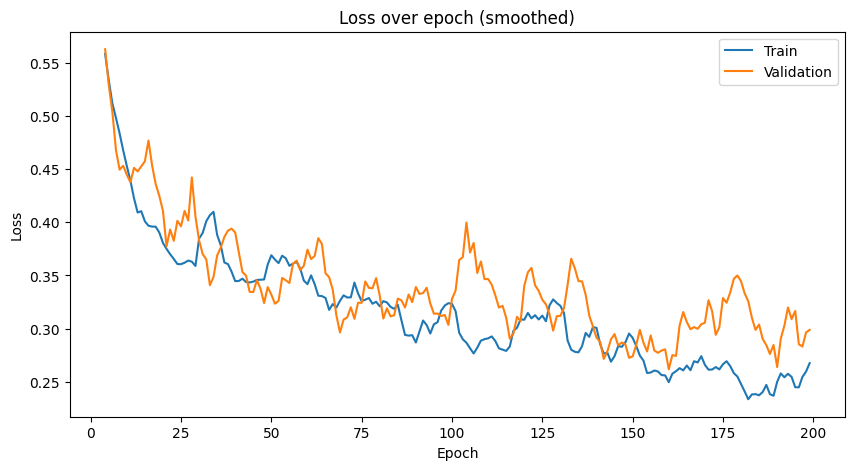

In [9]:
window_size = 5

s_metrics = metrics[['train loss', 'validation loss']].copy()
s_metrics['train loss'] = metrics['train loss'].rolling(window_size).mean()
s_metrics['validation loss'] = metrics['validation loss'].rolling(
    window_size).mean()

s_metrics.plot(y=['train loss', 'validation loss'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.show()

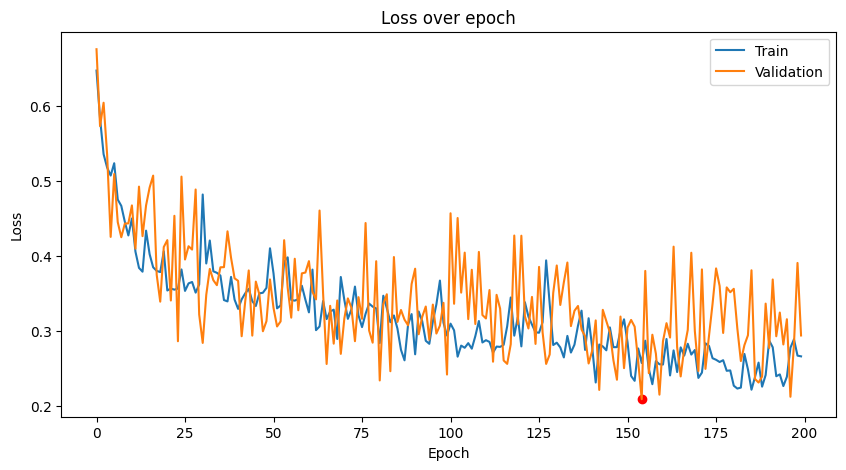

In [10]:
metrics.plot(y=['train loss', 'validation loss'], kind='line')

best_epoch = metrics['validation loss'].idxmin()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation loss'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Plot accuracy

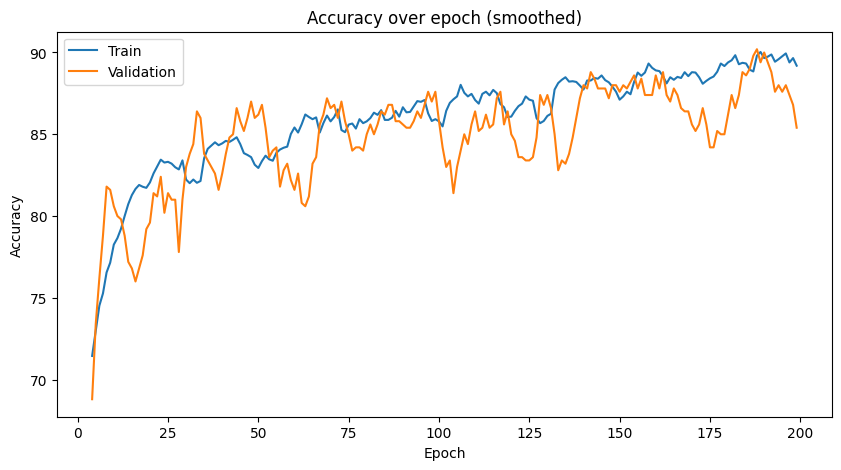

In [11]:
window_size = 5

s_metrics = metrics[['train accuracy', 'validation accuracy']].copy()
s_metrics['train accuracy'] = metrics['train accuracy'].rolling(
    window_size).mean()
s_metrics['validation accuracy'] = metrics['validation accuracy'].rolling(
    window_size).mean()

s_metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.show()

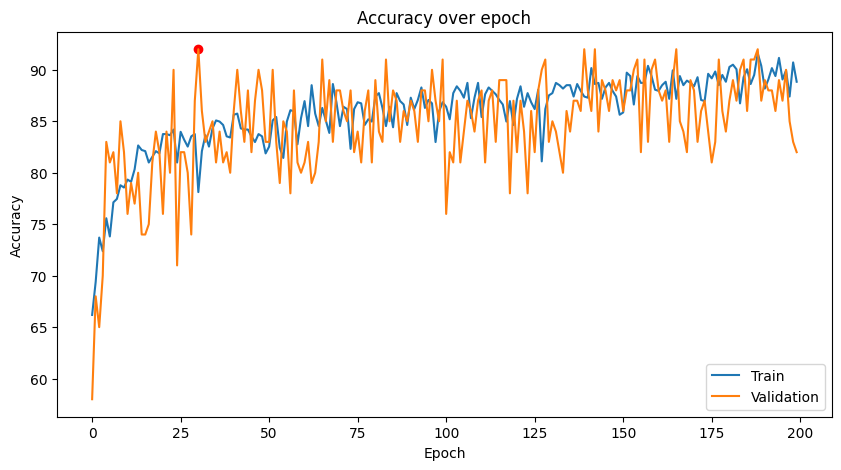

In [12]:
metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

best_epoch = metrics['validation accuracy'].idxmax()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation accuracy'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Create predictions

In [13]:
outs = torch.empty((0, 1))
targets = torch.empty((0, 1))
with torch.no_grad():
    for idx, (input, target) in enumerate(test_loader):
        input.requires_grad_(False)
        model.eval()
        out = model(input)
        outs = torch.cat([outs, out])
        targets = torch.cat([targets, target])

print(outs.shape)

torch.Size([1005, 1])


### Confusion matrix

In [14]:
print("Confusion matrix at t=0.1")
print(confusion(outs, targets, thresh=0.1))

print("Confusion matrix at t=0.3")
print(confusion(outs, targets, thresh=0.3))

print("Confusion matrix at t=0.6")
print(confusion(outs, targets, thresh=0.6))

print("Confusion matrix at t=0.8")
print(confusion(outs, targets, thresh=0.8))

Confusion matrix at t=0.1
[[477 165]
 [  4 359]]
Confusion matrix at t=0.3
[[558  84]
 [ 23 340]]
Confusion matrix at t=0.6
[[615  27]
 [ 81 282]]
Confusion matrix at t=0.8
[[635   7]
 [167 196]]


### Accuracy at different thresholds

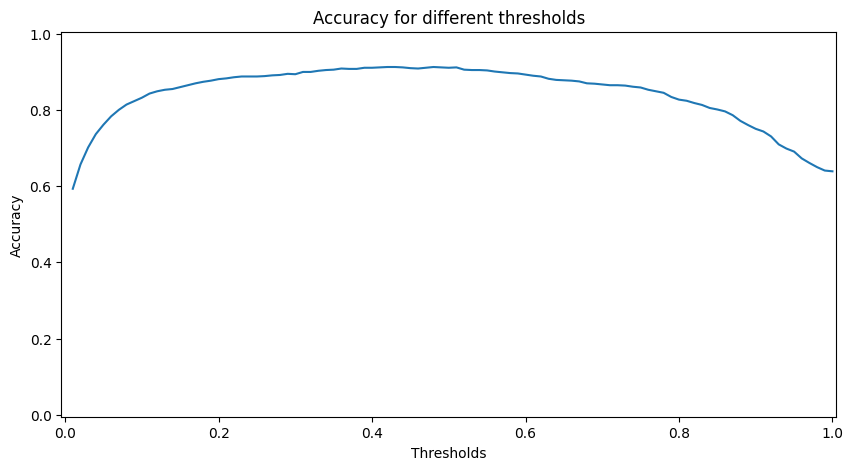

In [15]:
thresholds = np.arange(0.0,1.0,0.01) + 0.01

predictions = torch.empty((outs.shape[0], 0))
for thresh in thresholds:
    prediction = (outs > thresh) == targets
    predictions = torch.cat([predictions, prediction], dim=1)

thresh_wise_accuracy = predictions.mean(dim=0)
plt.plot(thresholds, thresh_wise_accuracy)
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.title('Accuracy for different thresholds')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.show()

### ROC curve

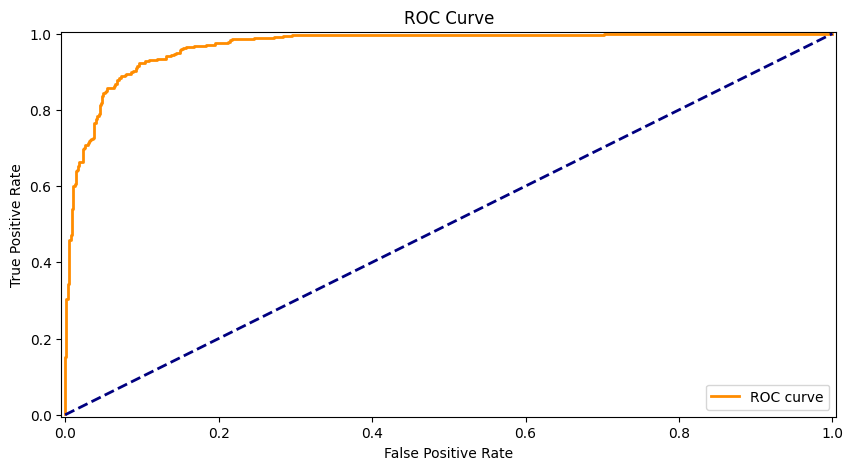

AUC: 0.9692163467407227


In [16]:
# Sort predictions and true labels by predicted probabilities
sorted_indices = torch.argsort(outs, descending=True, dim=0)
sorted_probs = outs[sorted_indices].squeeze()
sorted_labels = targets[sorted_indices].squeeze()

# Calculate True Positive Rate (tpr) and False Positive Rate (fpr) at various thresholds
tpr = torch.cumsum(sorted_labels, dim=0) / torch.sum(sorted_labels)
fpr = torch.cumsum(1 - sorted_labels, dim=0) / torch.sum(1 - sorted_labels)

# Plot ROC curve
plt.plot(fpr.numpy(), tpr.numpy(), color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.show()

# Calculate Area Under the Curve (AUC) using trapezoidal rule
roc_auc = torch.trapz(tpr, fpr)
print(f'AUC: {roc_auc.item()}')